# Forecasting Sales

In [30]:
# Standard Packages
import pandas as pd
import numpy as np
import warnings
import re
import time

# Viz Packages
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

# Modeling Packages
## Modeling Prep
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, \
GridSearchCV, RandomizedSearchCV

## SKLearn Data Prep Modules
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, \
PolynomialFeatures, PowerTransformer, Normalizer, MaxAbsScaler
from sklearn.impute import SimpleImputer

## SKLearn Random Forest
from sklearn.ensemble import RandomForestClassifier

## SKLearn Pipeline and Transformer
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## SKLearn Model Optimization
from sklearn.feature_selection import RFE, f_regression

## SKLearn Metrics
from sklearn.metrics import mean_absolute_error as MAE, mean_squared_error as MSE

## Statsmodel Time Series modules
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import SARIMAX, AutoReg
from statsmodels.tsa.stattools import adfuller

## Holidays package
from datetime import date
import holidays

In [31]:
# Notebook Config
## Suppress Python Warnings (Future, Deprecation)
warnings.filterwarnings("ignore", category= FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## Suppress Pandas Warnings (SettingWithCopy)
pd.options.mode.chained_assignment = None

## Pandas Display Config
pd.options.display.max_columns = None
pd.options.display.width = None

## Display SKLearn estimators as diagrams
from sklearn import set_config
set_config(display= 'diagram')

## Read in and Inspect the provided datasets

In [32]:
# Load the provided datasets
stores_df = pd.read_csv('data/stores.csv')
features_df = pd.read_csv('data/features.csv')
test_df = pd.read_csv('data/test.csv')
train_df = pd.read_csv('data/train.csv')

In [33]:
# inspect stores df
stores_df.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [34]:
stores_df.info() # no missing values, convert type to nominal or ordinal?

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [35]:
stores_df['Type'].value_counts()

A    22
B    17
C     6
Name: Type, dtype: int64

In [36]:
# Inspect the features data
features_df.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [37]:
features_df.info() # Missing markdown values as expected, some nulls for CPI and unemployment as well
# Need to convert 'Date' to datetime and 'IsHoliday' to numerical bool

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [38]:
features_df.isna().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

In [39]:
# Inspect the provided datasets
train_df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [40]:
train_df.info() # Has the most values - merge stores and features onto this dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [41]:
# Inspect the test data
test_df.head() # will need to also merge the stores and features datasets to our test set?

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [42]:
test_df.info() # roughly 80/20 train/test split

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Store      115064 non-null  int64 
 1   Dept       115064 non-null  int64 
 2   Date       115064 non-null  object
 3   IsHoliday  115064 non-null  bool  
dtypes: bool(1), int64(2), object(1)
memory usage: 2.7+ MB


In [43]:
# Combine datasets
train_df = train_df.merge(features_df, how='left').merge(stores_df, how='left')
train_df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,B,118221
421566,45,98,2012-10-05,628.10,False,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667,B,118221
421567,45,98,2012-10-12,1061.02,False,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667,B,118221
421568,45,98,2012-10-19,760.01,False,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667,B,118221


In [44]:
# Reorder columns to group similar features 
cols = list(train_df.columns.values)
cols # move 'Type' and 'Size' to after 'Dept', 'CPI' and 'Unemployment' after 'Fuel_Price'

['Store',
 'Dept',
 'Date',
 'Weekly_Sales',
 'IsHoliday',
 'Temperature',
 'Fuel_Price',
 'MarkDown1',
 'MarkDown2',
 'MarkDown3',
 'MarkDown4',
 'MarkDown5',
 'CPI',
 'Unemployment',
 'Type',
 'Size']

In [45]:
# rewrite df with new column ordering
train_df = train_df[['Store','Dept','Type','Size','Date','Weekly_Sales','IsHoliday','Temperature',
                         'Fuel_Price','CPI','Unemployment','MarkDown1','MarkDown2','MarkDown3','MarkDown4',
                         'MarkDown5']]

In [46]:
# Combine datasets for testing set to mirror training set
test_df = test_df.merge(features_df, how='left').merge(stores_df, how='left')
test_df

,Store,Dept,Date,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2012-11-02,False,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573,A,151315
1,1,1,2012-11-09,False,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573,A,151315
2,1,1,2012-11-16,False,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573,A,151315
3,1,1,2012-11-23,True,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573,A,151315
4,1,1,2012-11-30,False,52.34,3.207,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115059,45,98,2013-06-28,False,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,B,118221
115060,45,98,2013-07-05,False,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,B,118221
115061,45,98,2013-07-12,False,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,B,118221
115062,45,98,2013-07-19,False,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,B,118221


In [47]:
# add column to hold predicted weekly sales values 
test_df['Weekly_Sales'] = ''

In [48]:
# reorder columns to mirror transformation to training df
test_df = test_df[['Store','Dept','Type','Size','Date','Weekly_Sales','IsHoliday','Temperature',
                         'Fuel_Price','CPI','Unemployment','MarkDown1','MarkDown2','MarkDown3','MarkDown4',
                         'MarkDown5']]

In [49]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115064 entries, 0 to 115063
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         115064 non-null  int64  
 1   Dept          115064 non-null  int64  
 2   Type          115064 non-null  object 
 3   Size          115064 non-null  int64  
 4   Date          115064 non-null  object 
 5   Weekly_Sales  115064 non-null  object 
 6   IsHoliday     115064 non-null  bool   
 7   Temperature   115064 non-null  float64
 8   Fuel_Price    115064 non-null  float64
 9   CPI           76902 non-null   float64
 10  Unemployment  76902 non-null   float64
 11  MarkDown1     114915 non-null  float64
 12  MarkDown2     86437 non-null   float64
 13  MarkDown3     105235 non-null  float64
 14  MarkDown4     102176 non-null  float64
 15  MarkDown5     115064 non-null  float64
dtypes: bool(1), float64(9), int64(3), object(3)
memory usage: 14.2+ MB


## EDA

In [50]:
# check for nulls and dytpes again
train_df.info() # no nulls in CPI and Unemployment now, will need to see what's going there

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Type          421570 non-null  object 
 3   Size          421570 non-null  int64  
 4   Date          421570 non-null  object 
 5   Weekly_Sales  421570 non-null  float64
 6   IsHoliday     421570 non-null  bool   
 7   Temperature   421570 non-null  float64
 8   Fuel_Price    421570 non-null  float64
 9   CPI           421570 non-null  float64
 10  Unemployment  421570 non-null  float64
 11  MarkDown1     150681 non-null  float64
 12  MarkDown2     111248 non-null  float64
 13  MarkDown3     137091 non-null  float64
 14  MarkDown4     134967 non-null  float64
 15  MarkDown5     151432 non-null  float64
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB


<AxesSubplot: >

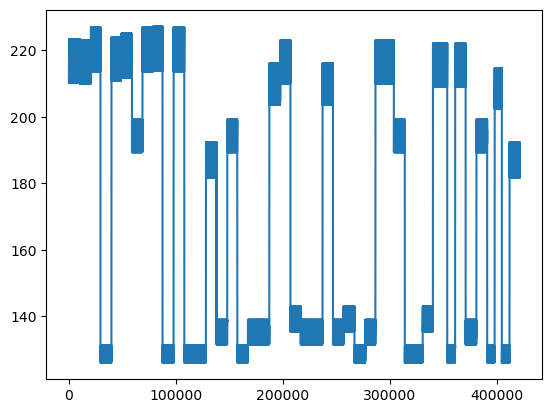

In [51]:
train_df['CPI'].plot()

<AxesSubplot: >

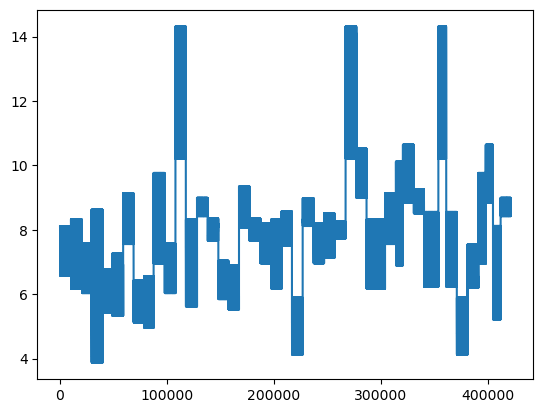

In [52]:
train_df['Unemployment'].plot()

In [53]:
train_df.isna().sum() # no more missing values - different reporting windows

Store                0
Dept                 0
Type                 0
Size                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
CPI                  0
Unemployment         0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
dtype: int64

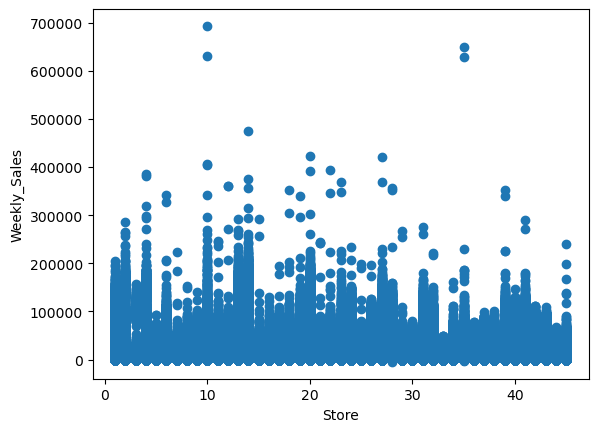

<Figure size 600x400 with 0 Axes>

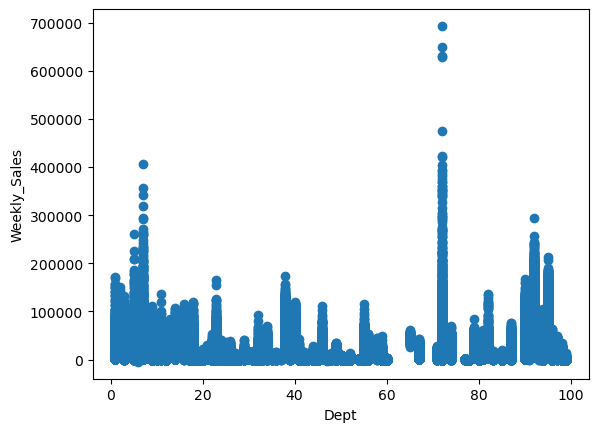

<Figure size 600x400 with 0 Axes>

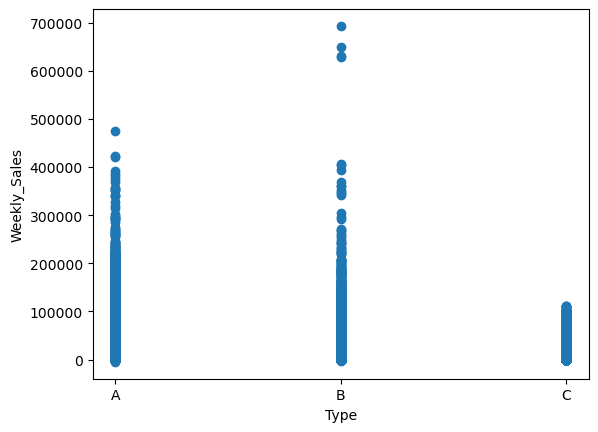

<Figure size 600x400 with 0 Axes>

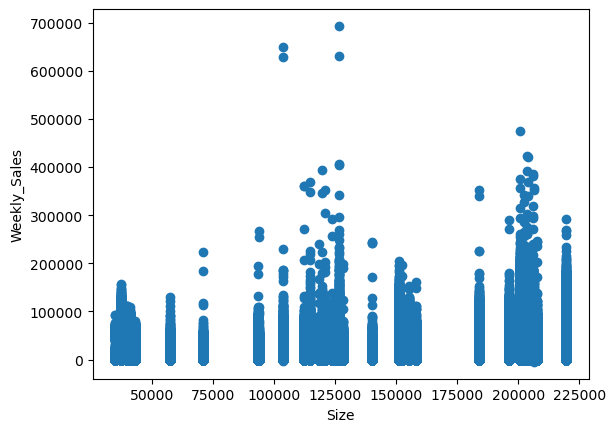

<Figure size 600x400 with 0 Axes>

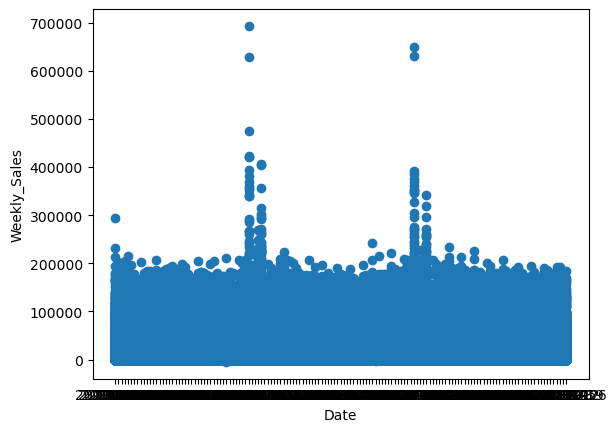

<Figure size 600x400 with 0 Axes>

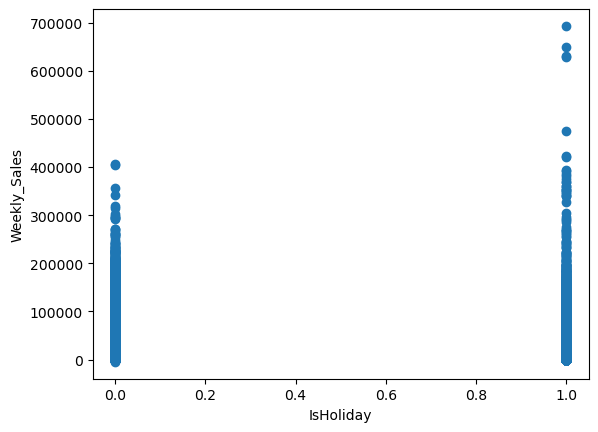

<Figure size 600x400 with 0 Axes>

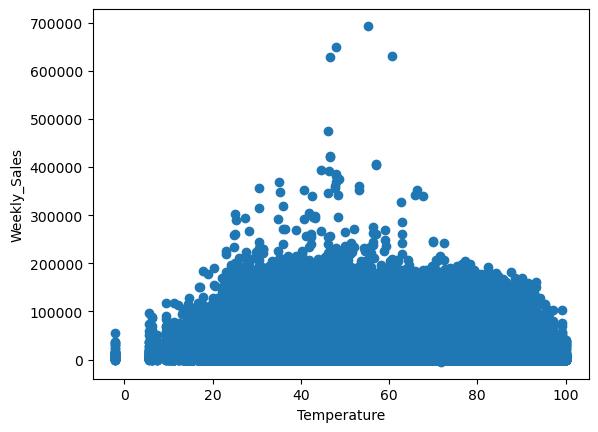

<Figure size 600x400 with 0 Axes>

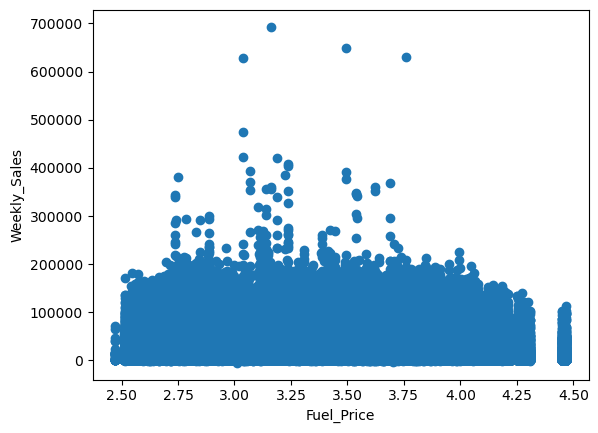

<Figure size 600x400 with 0 Axes>

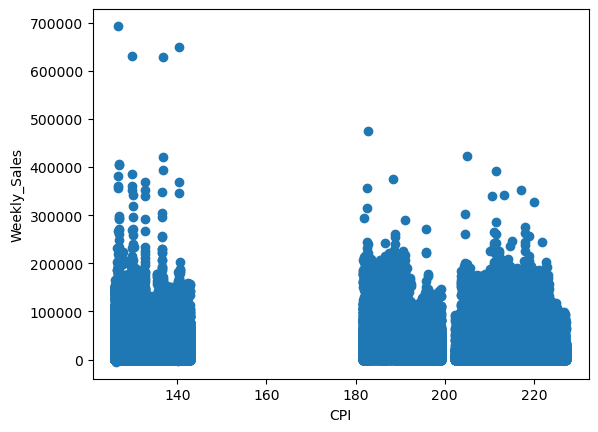

<Figure size 600x400 with 0 Axes>

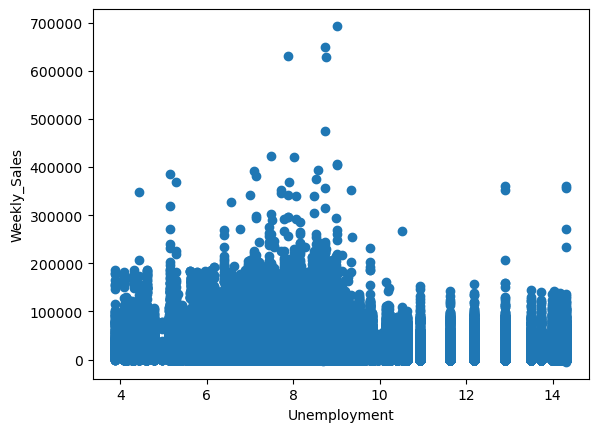

<Figure size 600x400 with 0 Axes>

In [54]:
# Visualize feature distributions excl markdown and sales cols with scatter plots
cols_to_scatter = ['Store','Dept','Type','Size','Date','IsHoliday','Temperature',
                   'Fuel_Price','CPI','Unemployment']
for col in cols_to_scatter:
    plt.figure()
    plt.scatter(train_df[col], train_df['Weekly_Sales'])
    plt.xlabel(col)
    plt.ylabel('Weekly_Sales')
    plt.figure(figsize=(6,4))

While some type 'B' and midsize stores have sales numbers bigger than some type 'A' and larger stores, we'll handle type ordinally
- big drop off when store type is 'C'

Two huge sales bumps in the date plot
- guessing its thanksgiving/black friday and christmas, but we'll want to drill down on that later 


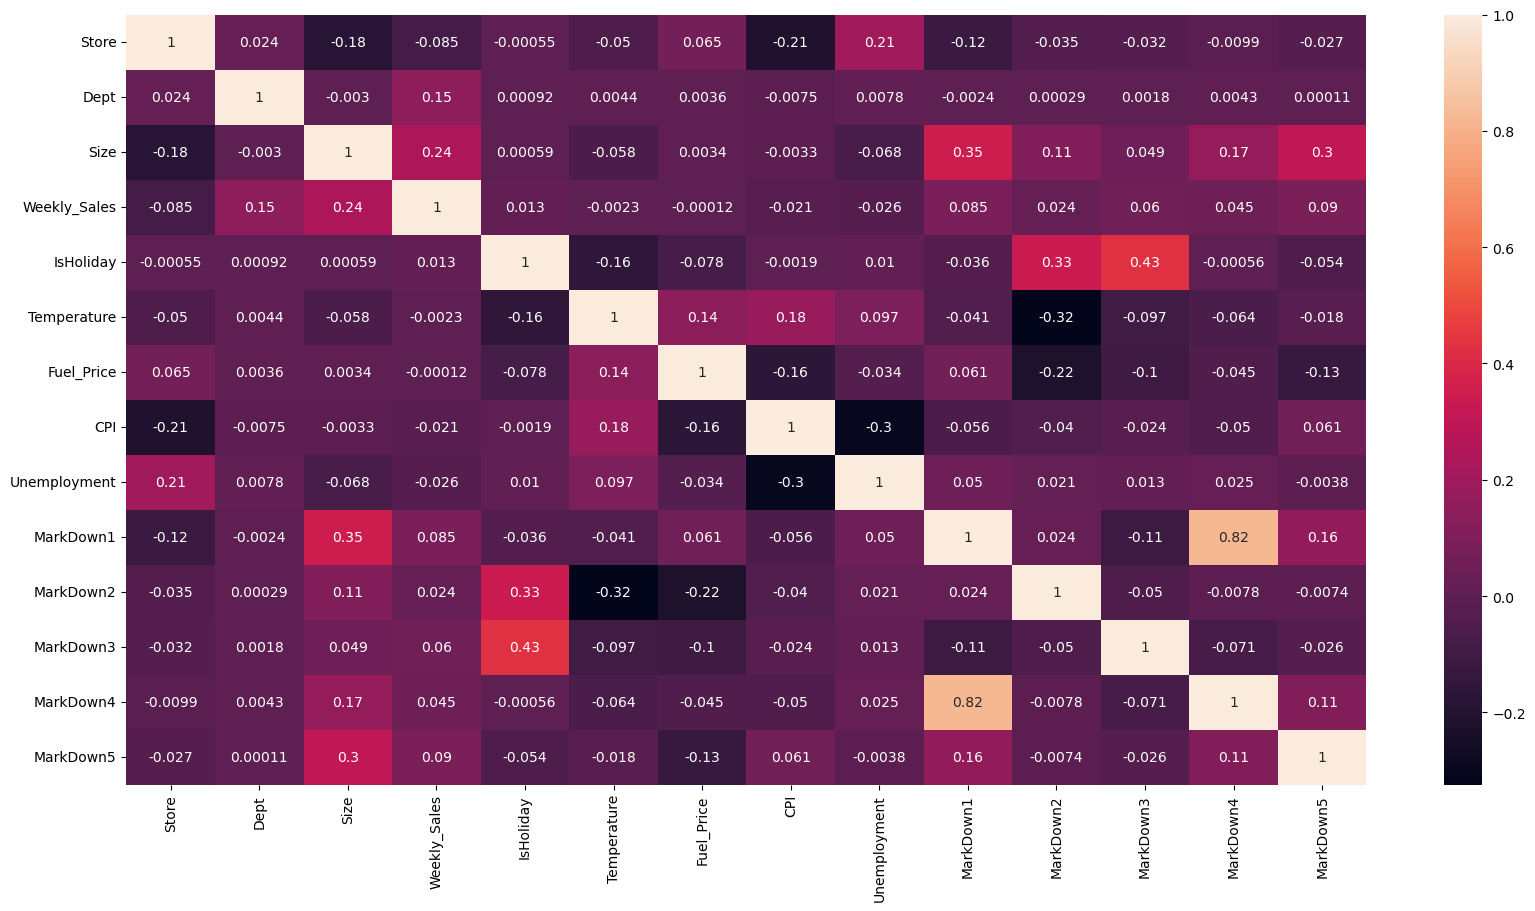

In [55]:
# Check correlation of numerical features
plt.figure(figsize=(20,10))
cor = train_df.corr()
sns.heatmap(cor, annot=True)
plt.show()

- nothing really jumps out as being highly correlated
- unexpectedly low correlation for many features such as markdowns and external factors such as CPI, gas prices, and the unemployment rate
- could be a case where the best predictor of future values is truly past values

In [56]:
# Extract years, months, weeks from the date and weekly sales into new cols for testing and training dfs
# allows us to group sales by diffrent windows and plot so we can look for trends
# Also necessary for running models later on
# Convert date col to datetime object for training and test sets
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])

# Extract Years, Months, and Weeks from date col in both sets
train_df['Year'] = train_df['Date'].dt.year
train_df['Month'] = train_df['Date'].dt.month
train_df['Week'] = train_df['Date'].dt.week

test_df['Year'] = test_df['Date'].dt.year
test_df['Month'] = test_df['Date'].dt.month
test_df['Week'] = test_df['Date'].dt.week

In [57]:
# Aggregate average sales by year by week to indentify trends in weekly sales 
weekly_2010 = train_df.loc[train_df['Year'] == 2010].groupby('Week')['Weekly_Sales'].mean()
weekly_2011 = train_df.loc[train_df['Year'] == 2011].groupby('Week')['Weekly_Sales'].mean()
weekly_2012 = train_df.loc[train_df['Year'] == 2012].groupby('Week')['Weekly_Sales'].mean()

In [58]:
weekly_2012

Week
1     15121.231736
2     14168.266514
3     14221.357405
4     13494.232612
5     15480.553608
6     16664.247891
7     16693.401051
8     15458.124475
9     15672.586946
10    15965.182956
11    15823.719615
12    15195.472627
13    15289.720371
14    17935.741157
15    15663.171451
16    15150.430178
17    14799.187167
18    15947.275103
19    15784.015806
20    15856.396620
21    16284.414590
22    16405.589439
23    16774.044520
24    16377.574662
25    16098.711574
26    15887.184494
27    17309.362337
28    15616.440413
29    15602.826372
30    15034.829516
31    16004.684719
32    16030.926967
33    16025.195279
34    16029.501216
35    15921.552812
36    16294.692957
37    14905.978648
38    14989.708385
39    14765.327279
40    15983.413747
41    15427.596739
42    15295.732397
43    15391.725681
Name: Weekly_Sales, dtype: float64

## Save this for the propeht modeling which takes a holiday argument

In [28]:
# get list of US holidays from the holidays python package for the applicable years (2010,2011,2012)
for date, name in sorted(holidays.US(years=[2010,2011,2012]).items()):
    print(date, name)

2010-01-01 New Year's Day
2010-01-18 Martin Luther King Jr. Day
2010-02-15 Washington's Birthday
2010-05-31 Memorial Day
2010-07-04 Independence Day
2010-07-05 Independence Day (Observed)
2010-09-06 Labor Day
2010-10-11 Columbus Day
2010-11-11 Veterans Day
2010-11-25 Thanksgiving
2010-12-24 Christmas Day (Observed)
2010-12-25 Christmas Day
2010-12-31 New Year's Day (Observed)
2011-01-01 New Year's Day
2011-01-17 Martin Luther King Jr. Day
2011-02-21 Washington's Birthday
2011-05-30 Memorial Day
2011-07-04 Independence Day
2011-09-05 Labor Day
2011-10-10 Columbus Day
2011-11-11 Veterans Day
2011-11-24 Thanksgiving
2011-12-25 Christmas Day
2011-12-26 Christmas Day (Observed)
2012-01-01 New Year's Day
2012-01-02 New Year's Day (Observed)
2012-01-16 Martin Luther King Jr. Day
2012-02-20 Washington's Birthday
2012-05-28 Memorial Day
2012-07-04 Independence Day
2012-09-03 Labor Day
2012-10-08 Columbus Day
2012-11-11 Veterans Day
2012-11-12 Veterans Day (Observed)
2012-11-22 Thanksgiving
2012

Thanksgiving and Black Friday (tgiving +1) always fall in november
- could categorize month 11 as 'thanksgiving' or assign thanksgiving and black friday to the appropriate week number

New Years is technically always in a new week/month/year, however case to be made for grouping with xmas
- could categorize month 12 as xmas & new years or assign to the appropriate week number
- more inclined to encode on monthly basis as trend has been for an ever longer holiday shopping window

Holidays to look at not included in the standard list are:
- Super bowl weekend (
- Valentine's day 
- Easter

Holidays not associated with high levels of consumerism to remove
- Martin Luther King Jr. Day
- Washington's Birthday
- Veterans Day
- Columbus Day
- 'Observed' dates

Other Notes:
- Labor day is not in the test set so we don't need to predict for that
